In [82]:
import pandas as pd
from glob import glob
import itertools
from collections import Counter
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
import time
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import powerlaw

In [24]:
# seperate the date-files into user-files
files=glob('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/date/*')

column_list = 'user_id,access_mode_id,logic_area_name,lac,ci,longtitude,latitude,busi_name,busi_type_name,\
app_name,app_type_name,start_time,up_pack,down_pack,up_flow,down_flow,site_name,site_channel,cont_app_id,\
cont_classify_id,cont_type_id,acce_url'.split(',')

for i in files:
    data=pd.read_csv(i,names=column_list,usecols=['user_id','busi_name','start_time'])    
    users=data['user_id'].drop_duplicates()
    groups=data.groupby('user_id')
    
    for user in users:
        df=groups.get_group(user)
        with open('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/allusers/' + str(user) +'.csv', 'a+') as f:
            df.to_csv(f,header=False)

In [64]:
# first put all the unique nodes together, second all pair combinations together,third pair combinations for every user
files=glob('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/allusers/*')
for f in files:
    user=f.split('/')[-1].split('.')[0]
    userdata=pd.read_csv(f,names=['user_id','busi_name','start_time'])
    userdata=userdata.drop(['start_time'],axis=1)
    userdata=userdata.drop_duplicates()
    userdata=userdata[userdata['busi_name']!='其他']
    
    userdata.to_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/node.csv',header=False,mode='a+')
    
    busi_list=userdata['busi_name'].values
    pair=list(itertools.combinations(busi_list,2))
    data=pd.DataFrame(pair)
    data.to_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/pair.csv',header=False,mode='a+')
    
        
    with open('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/pair/' + str(user) +'.csv', 'a+') as f:
        data.to_csv(f,header=False)

In [67]:
# observed values
busi_obs=pd.read_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/pair.csv',names=['node1','node2'],index_col=0)
busi_obs['pair']=busi_obs['node1'].astype('str')+' '+busi_obs['node2'].astype('str')
counterdict=Counter(busi_obs['pair'].values)
counterdict=pd.DataFrame(list(counterdict.items()),columns=['pair','busi_obs'])
counterdict.to_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/observed_value.csv')

In [19]:
# expected values
for i in range (10):
    name='busi_exp'+str(i)
    name=pd.read_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/node.csv',index_col=0,names=['user_id','busi_name'])
    numpy.random.shuffle(name['busi_name'].values)
    users=name['user_id'].drop_duplicates()
    groups=name.groupby('user_id')
    
    path='/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/expected_value/'
    f=path+'busi_exp'+str(i)+'.csv'

    for user in users:
        userdata=groups.get_group(user)
        userdata=userdata.drop_duplicates()

        busi_list=userdata['busi_name'].values
        pair=list(itertools.combinations(busi_list,2))
        busi_exp=pd.DataFrame(pair)
        busi_exp.to_csv(f,header=0,mode='a+')

    busi_exp=pd.read_csv(f,names=['node1','node2'])   
    busi_exp['pair']=busi_exp['node1'].astype('str')+' '+busi_exp['node2'].astype('str')
    counterdict=Counter(busi_exp['pair'].values)
    counterdict=pd.DataFrame(list(counterdict.items()),columns=['pair','busi_obs'])
    counterdict.to_csv(f,header=0,mode='w')

In [8]:
# combine observed value and expected value
files=glob('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/expected_value/*')

for f in files:
    name=f.split('/')[-1].split('.')[0]
    data=pd.read_csv(f,names=['pair','count'])
    diction=dict(data[['pair','count']].values)
    z_score=pd.read_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/observed_value.csv',index_col=0)
    z_score[name]=z_score['pair'].apply(lambda x: diction[x]
                                                    if x in diction
                                                    else numpy.nan)
    z_score.to_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/observed_value.csv')

In [11]:
# z_score
z_score=pd.read_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/observed_value.csv',index_col=0)
z_score=z_score.fillna(0)
mean=z_score.iloc[:,[x for x in range(2,12)]].mean(axis=1)
std=z_score.iloc[:,[x for x in range(2,12)]].std(axis=1)
z_score['z_score']=(z_score['busi_obs']-mean)/std
z_score.to_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/observed_value.csv')

In [12]:
# put z_score into every user-file
z_score=pd.read_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/observed_value.csv',usecols=['pair','z_score'])
diction=dict(z_score.values)

files=glob('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/pair/*')

for f in files:
    data=pd.read_csv(f,names=['node1','node2'])
    data['pair']=data['node1'].astype('str')+' '+data['node2'].astype('str')
    data['z_score']=data['pair'].apply(lambda x: diction[x]
                                  if x in diction
                                   else np.nan)
    data.to_csv(f)

In [15]:
# four categories group by z_score
files=glob('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/pair/*')
lista=[]
listb=[]
listc=[]
for f in files:
    data=pd.read_csv(f)
    if len(data['z_score'])>0:
        user_id=f.split('/')[-1].split('.')[0]
        lista.append(user_id)
        a=numpy.array(data['z_score'].values)
        median=numpy.median(a)
        listb.append(median)
        pertentile_10=numpy.percentile(a,10)
        listc.append(pertentile_10)
df=pd.DataFrame([lista,listb,listc]).T
df.columns=['user_id','median','pertentile_10']
df.to_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/zscore_category.csv')

df=df[~df.isin([numpy.nan, numpy.inf, -numpy.inf]).any(1)]

high_low=df[(df['median']>df['median'].median())&(df['pertentile_10']>0)]['user_id']
high_low.to_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/high_low')

low_low=df[(df['median']<=df['median'].median())&(df['pertentile_10']>0)]['user_id']
low_low.to_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/low_low')

low_high=df[(df['median']<=df['median'].median())&(df['pertentile_10']<=0)]['user_id']
low_high.to_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/low_high')

high_high=df[(df['median']>df['median'].median())&(df['pertentile_10']<=0)]['user_id']
high_high.to_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/high_high')

In [48]:
# entropy 1
def contains(small, big):
    for i in range(len(big) - len(small)):
        if big[i] == small[0]:
            if big[i:i + len(small)] == small:
                return True
    return False

def actual_entropy(l):
    n = len(l)
    if n > 1:
        sequence = [l[0]]
        sum_gamma = 0

        starttime = time.time()
        for i in range(1, n):
            if i % 1000 == 0:
                print(i)
                endtime = time.time()
                print(endtime - starttime)
                starttime = time.time()

            for j in range(i + 1, n + 1):
                s = list(l[i:j])
                # print(list(l[i:j]))
                # print('sequence', sequence, s, '\n')
                if not contains(s, sequence):
                    # print('gamma_i', len(s), '\n')
                    sum_gamma += len(s)
                    sequence.append(l[i])
                    break

                    #     print(sum_gamma)
    
        ae = 1 / (sum_gamma / n) * math.log(n)
    else:
        ae = 0
    return ae

# file=pd.read_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/allusers/37924550.csv')
# userdata=pd.read_csv(f,names=['user_id','busi_name','start_time'])
# userdata=userdata.drop_duplicates()
# userdata=userdata[userdata['busi_name']!='其他']
# userdata=userdata.sort_values(by=['start_time'])
# a=userdata['busi_name'].values                             
# actual=actual_entropy(a)
# print(actual)



files=glob('/Users/xuhuimin/Documents/lab/labdata/beijingmobile/dateexample/allusers/*')
users = [i.strip('.csv').split('/')[-1] for i in files]

actual=[]
for f in files:   
    userdata=pd.read_csv(f,names=['user_id','busi_name','start_time'])
    userdata=userdata.drop_duplicates()
    userdata=userdata[userdata['busi_name']!='其他']
    userdata=userdata.sort_values(by=['start_time'])
    a=userdata['busi_name'].values                             
    actual.append(actual_entropy(a))

user_entropy = pd.DataFrame(users, columns=['user'])
user_entropy['actual']= actual

user_entropy.to_csv('/Users/xuhuimin/Documents/lab/labdata/beijingmobile/dateexample/user_entropy.csv')

1000
0.1463623046875
1000
0.174591064453125
1000
0.12586212158203125
1000
0.15208101272583008
1000
2.7474889755249023
1000
0.10683822631835938
1000
0.14311003684997559
1000
0.12099409103393555
1000
0.8573272228240967
2000
4.376962900161743
3000
14.011039972305298
4000
10.120400190353394
5000
7.2119059562683105
6000
10870.578643083572
1000
0.13430190086364746
1000
0.2678358554840088
2000
0.9783859252929688
3000
8.836075782775879
4000
27.90078592300415
5000
249.18540382385254
6000
20.900145292282104
7000
36.01959800720215
8000
7.684044122695923
9000
8.842369079589844
10000
9.79210615158081
11000
7.514717102050781
1000
0.1773538589477539
2000
0.5824050903320312
3000
1.0536000728607178
4000
1.3478310108184814
5000
1.8610329627990723
1000
0.1685161590576172
1000
0.23033881187438965
1000
6.408228158950806
2000
22.62952995300293
3000
16.29896306991577
4000
6.762297868728638
5000
18.73482894897461
6000
44.67961287498474
7000
46.764671087265015
8000
108.14769697189331
9000
139.30517029762268
10

KeyboardInterrupt: 

In [28]:
# entropy 2
def contains(small, big):
    try:
        big.tostring().index(small.tostring())//big.itemsize
        return True
    except ValueError:
        return False

def actual_entropy(l):

    n = len(l)
    

    sum_gamma = 0

    for i in range(1, n):
        sequence = l[:i]

        for j in range(i+1, n+1):
            s = l[i:j]
            if contains(s, sequence) != True:
                sum_gamma += len(s)
                break
                    
    if n > 1:
        ae = 1 / (sum_gamma / n) * math.log(n)
    else:
        ae = 0
    return ae

# file=pd.read_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/allusers/37924550.csv')
# userdata=pd.read_csv(f,names=['user_id','busi_name','start_time'])
# userdata=userdata.drop_duplicates()
# userdata=userdata[userdata['busi_name']!='其他']
# userdata=userdata.sort_values(by=['start_time'])
# a=userdata['busi_name'].values                             
# actual=actual_entropy(a)
# print(actual)

files=glob('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/allusers/*')
users = [i.strip('.csv').split('/')[-1] for i in files]

actual=[]
for f in files:   
    userdata=pd.read_csv(f,names=['user_id','busi_name','start_time'])
    userdata=userdata.drop_duplicates()
    userdata=userdata[userdata['busi_name']!='其他']
    userdata=userdata.sort_values(by=['start_time'])
    a=userdata['busi_name'].values                             
    actual.append(actual_entropy(a))

user_entropy = pd.DataFrame(users, columns=['user'])
user_entropy['actual']= actual

ZeroDivisionError: float division by zero

In [ ]:
# add category

df=pd.read_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/zscore_category.csv',index_col=0)
df=zscore_category[~df.isin([numpy.nan, numpy.inf, -numpy.inf]).any(1)]

high_low=df[(df['median']>df['median'].median())&(df['pertentile_10']>0)].index
df.ix[high_low,'category']='high_low'


low_low=df[(df['median']<=df['median'].median())&(df['pertentile_10']>0)].index
df.ix[low_low,'category']='low_low'

low_high=df[(df['median']<=df['median'].median())&(df['pertentile_10']<=0)].index
df.ix[low_high,'category']='low_high'

high_high=df[(df['median']>df['median'].median())&(df['pertentile_10']<=0)].index
df.ix[high_high,'category']='high_high'

df=df[['user_id','median','pertentile_10','category']]
df.to_csv('/Users/xuhuimin/Documents/lab/lab data/beijingmobile/dateexample/zscore_category.csv')

In [2]:
# fetch the valid information sex age fees brand terminal_price to zscore_category
columns = 'user_id，sex，age，occupation_name，education_name，user_opentime，brand_name，call_duration_m，gprs_flow，\
call_fee，gprs_fee，databusiness_fee，order_name，brand_chn，model_chn，screensize，operation_sys，terminal_price，\
dept_county_name，dept_name'.split('，')

basename=pd.read_csv('/Users/xuhuimin/Documents/lab/labdata/beijingmobile/basename.csv', encoding='gbk', names=columns)
basename=basename.drop_duplicates()
basename=basename.fillna(0)
basename['fees']=basename['call_fee']+basename['gprs_fee']+basename['databusiness_fee']

In [14]:
df=pd.read_csv('/Users/xuhuimin/Documents/lab/labdata/beijingmobile/dateexample/zscore_category.csv',index_col=0)

names=['sex','age','brand_chn','terminal_price']
for n in names:
    diction=dict(basename[['user_id',n]].values)
    df[n]=df['user_id'].apply(lambda x: diction[x]
                                 if x in diction
                                 else numpy.nan)
    
# diction=dict(basename[['user_id','fees']].values)
# df['fees']=df['user_id'].apply(lambda x: diction[x]
#                              if x in diction
#                              else numpy.nan)

df.to_csv('/Users/xuhuimin/Documents/lab/labdata/beijingmobile/dateexample/zscore_category.csv')


In [25]:
# fetch the valid information unique business to zscore_cstegory
unique_busi=pd.read_csv('/Users/xuhuimin/Documents/lab/labdata/beijingmobile/dateexample/node.csv',index_col=0)
unique_busi.columns=['user_id','node']
unique_busi=unique_busi.groupby('user_id')['node'].nunique()

df=pd.read_csv('/Users/xuhuimin/Documents/lab/labdata/beijingmobile/dateexample/zscore_category.csv',index_col=0)

diction=dict(zip(unique_busi.index,unique_busi.values))
df['unique_busi']=df['user_id'].apply(lambda x: diction[x]
                             if x in diction
                             else numpy.nan)

df.to_csv('/Users/xuhuimin/Documents/lab/labdata/beijingmobile/dateexample/zscore_category.csv')


In [72]:
# cumulative distribution 
data=pd.read_csv('/Users/xuhuimin/Documents/lab/labdata/beijingmobile/dateexample/zscore_category.csv',usecols=['median','percentile_10'])

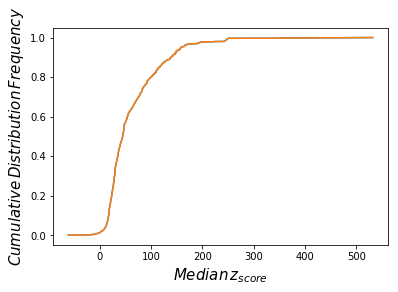

In [77]:
median=data['median'].values
x, px = powerlaw.cdf(median)
plt.plot(x, px)
plt.xlabel('$Median\,z_{score}$',fontsize=15)
plt.ylabel('$Cumulative\,Distribution\,Frequency$',fontsize=15)

# x0=0

# plt.plot([x0, x0,], [0, y0,], 'k--', linewidth=1.0)
# plt.scatter([x0, ],[y0, ], s=50, color='r') 

# plt.yscale('log')
# plt.xscale('log')
plt.show()

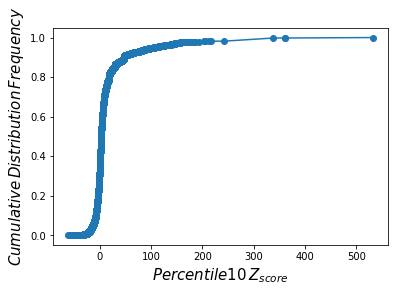

In [106]:
percentile_10=data['percentile_10'].values
x, px = powerlaw.cdf(percentile_10)
plt.plot(x, px)
plt.xlabel('$Percentile10\,Z_{score}$',fontsize=15)
plt.ylabel('$Cumulative\,Distribution\,Frequency$',fontsize=15)

# x0=0

# plt.plot([x0, x0,], [0, y0,], 'k--', linewidth=1.0)
# plt.scatter([x0, ],[y0, ], s=50, color='r') 

# plt.yscale('log')
# plt.xscale('log')
plt.show()

In [90]:
# pick out the 5% highest fees and terminal price
data=pd.read_csv('/Users/xuhuimin/Documents/lab/labdata/beijingmobile/dateexample/zscore_category.csv',index_col=0)

In [103]:
highest_fees=data.sort_values(by=['fees'],ascending=False)[:int(len(data)*0.05)]
print(len(highest_fees[highest_fees.category=='low_high']))
print(len(highest_fees[highest_fees.category=='low_low']))
print(len(highest_fees[highest_fees.category=='high_high']))
print(len(highest_fees[highest_fees.category=='high_low']))

625
875
315
1300


In [104]:
highest_termnial=highest_fees=data.sort_values(by=['terminal_price'],ascending=False)[:int(len(data)*0.05)]
print(len(highest_fees[highest_fees.category=='low_high']))
print(len(highest_fees[highest_fees.category=='low_low']))
print(len(highest_fees[highest_fees.category=='high_high']))
print(len(highest_fees[highest_fees.category=='high_low']))

374
468
360
1913


In [ ]:
# K-S tests

In [ ]:
>>> from scipy.stats import ks_2samp
>>> import numpy as np
>>> 
>>> np.random.seed(12345678)
>>> x = np.random.normal(0, 1, 1000)
>>> y = np.random.normal(0, 1, 1000)
>>> z = np.random.normal(1.1, 0.9, 1000)
>>> 
>>> ks_2samp(x, y)
Ks_2sampResult(statistic=0.022999999999999909, pvalue=0.95189016804849647)
>>> ks_2samp(x, z)
Ks_2sampResult(statistic=0.41800000000000004, pvalue=3.7081494119242173e-77)

In [2]:
# study the relationship between different variables

data=pd.read_csv('/Users/xuhuimin/Documents/lab/labdata/beijingmobile/dateexample/zscore_category.csv',usecols=['median','percentile_10','terminal_price','fees','unique_busi'])

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


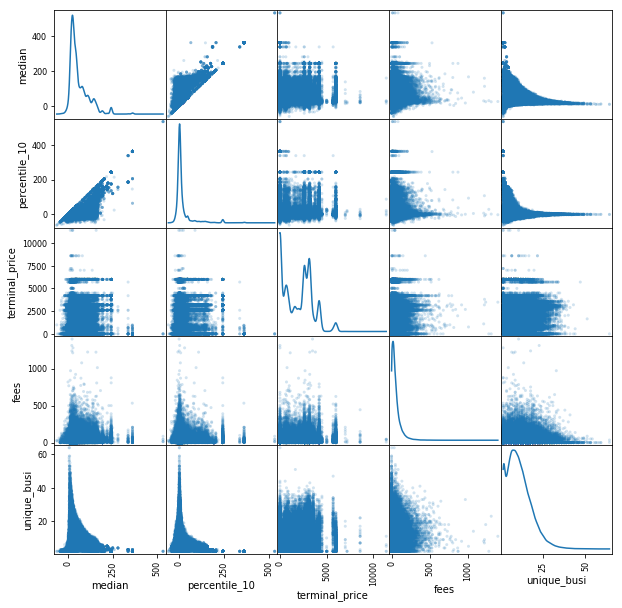

In [20]:
# data=[['median','percentile_10','terminal_price','fees','unique_busi']]
scatter_matrix(data,alpha=0.2,figsize=(10,10),diagonal='kde')
plt.show()

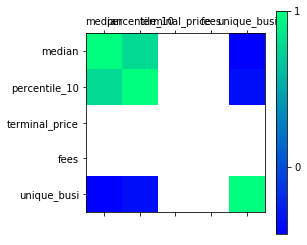

In [23]:
cov = np.corrcoef(data.T)
img = plt.matshow(cov,cmap=plt.cm.winter)
plt.colorbar(img, ticks=[-1,0,1])
plt.xticks(np.arange(len(data.keys())), data.keys())
plt.yticks(np.arange(len(data.keys())), data.keys())
# plt.savefig('/Users/xuhuimin/Desktop/1.png',dpi=100)
plt.show()

In [ ]:
# category the users into two categories accooding to the degree of fragmentation

In [26]:
column_list = 'user_id,access_mode_id,logic_area_name,lac,ci,longtitude,latitude,busi_name,busi_type_name,\
app_name,app_type_name,start_time,up_pack,down_pack,up_flow,down_flow,site_name,site_channel,cont_app_id,\
cont_classify_id,cont_type_id,acce_url'.split(',')

example=pd.read_csv('/Users/xuhuimin/Documents/lab/labdata/beijingmobile/userexample/user_41516201.csv',names=column_list)

In [ ]:
example=example[['user_id','site_name',]]